# 杭州互联网寒冬下的数据分析岗现状分析

****

- 学员昵称：米竹314159
- 学员编号：822122

## 目录

- [绪论](#绪论)
- [数据获取](#数据获取)
- [数据预处理](#数据预处理)
- [数据分析](#数据分析)
- [总结](#总结)

## 绪论

### 背景

数据分析是我比较心仪的发展方向。利用数据来定性且定量地解决（解释和预测）问题，酷极。且数据分析广泛地存在于各行各业中，加之行业的业务理解，简直就是万金油，妙极。   
2018年互联网行业面临着又一轮的寒冬，大小公司裁员、缩招，一时满城风雨。互联网行业是数据分析师职业发展较好的温室，且其提供的就业机会（数据分析岗）也是相对最多的。因此倘若互联网行业确是面临凛冽寒风，那对（全行业的）数据分析岗的冲击无疑会是不可忽视的。
退一步说，潮起潮落，再正常不过了。（寒冬都到了，暖春还会远吗？）但这股寒潮仍是给我敲响了警钟，原以为数据分析岗仍会很抢手，是我一直以来都安逸惯了。因此对杭州市网上招聘的数据（选择杭州原因有二：其一是在智联只能爬到1080条数据，对于全国来说n太小，会产生较大的偏差；其二是本人打算在杭州发展，且杭州作为互联网大市，能提供一定的数据支持（见下图 2-1））进行爬取分析，管中窥豹，大致了解当下的数据分析岗(与数据分析相关的岗位)现状，为将来的就业做好初步的规划。

Text(0.5,1,'图2-1 全国数据分析岗招聘数条形图(前12)')

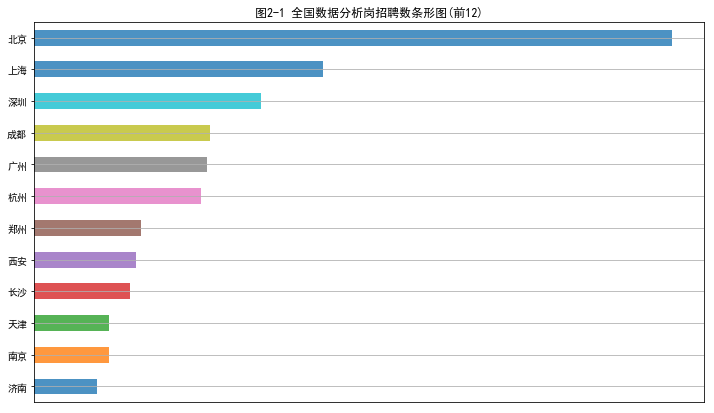

In [1]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

warnings.filterwarnings('ignore')

# 绘制条形图
city_df = pd.read_excel('NationalJobs_da.xlsx')['city']
barh_series = city_df.value_counts()[:12].sort_values(
    ascending=True)  # 取前12个城市
barh_series.plot.barh(grid=True, alpha=0.8, figsize=(12, 7))
plt.xticks([])
plt.title('图2-1 全国数据分析岗招聘数条形图(前12)')  # n不够大，仅做参考！

### 介绍

本次项目采集[智联招聘](https://www.zhaopin.com/)杭州站的招聘信息，主要分为公司基本信息、职位基本信息、职位要求信息这三部分。注意：智联招聘最多只展示12页（90\*12条）信息，展示数据来自于智联招聘的匹配系统，可能不能很好的代表总体的信息。
再通过数据预处理将数据处理为可以分析的干净数据。  
通过对招聘详细描述信息绘制词云图进行可视化分析，对公司、职位的基本信息和职位的要求信息进行描述性分析，最后通过关联规则发现了招聘者对于求职者软件能力要求之间的相关关系。 

------------

## 数据获取

本次项目采集自[智联招聘](https://www.zhaopin.com/)全国站/杭州站的数据分析岗招聘信息，主要有公司基本信息、职位基本信息、职位要求信息这三部分。  
[总数据说明](#总数据说明)以及[预处理后的数据](#预处理后的数据说明)见下文。

### 爬虫详情

In [2]:
# 网页分析: 大部分的招聘信息可以通过智联招聘给出的API直接获取，招聘人数以及职业描述的文本数据等信息则需要在信息详情页进行采集。
import re
import time
import random

import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from requests.exceptions import RequestException

import warnings
warnings.filterwarnings('ignore')

# 杭州站的基础url
hangzhou_url = 'https://fe-api.zhaopin.com/c/i/sou?start={}&pageSize=90&cityId=653&workExperience=-1&education=-1' \
               '&companyType=-1&employmentType=-1&jobWelfareTag=-1&kw=%E6%95%B0%E6%8D%AE%E5%88%86%E6%9E%90&kt=3' \
               '&_v=0.56941966&x-zp-page-request-id=15e5b2a55f484f4da5e0be92d842b06e-1548030421680-768527'
# 请求头信息
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36'}


def get_response(url, headers):
    '''
    获取响应

    参数：
    url     -- 目标站点
    headers -- 请求头信息
    返回：
    若目标站点成功访问，返回其返回的响应信息
    '''
    try:
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            return response
        return None
    except RequestException:
        return None


def parse_data(max_num, step):
    '''
    解析数据

    参数：
    max_num -- 循环的最大次数(循环翻页)
    step    -- 循环的步长
    '''
    # 初始化一个列表，用于存放各页的信息
    page_info = []

    # 依次解析各页的数据
    for i in range(0, max_num, step):
        url = hangzhou_url.format(i)    # 组装每页的url
        results = get_response(url, headers=headers).json().get(
            'data').get('results')    # 从响应信息中获取需要的字典数据
        print('准备获取第{}页的信息 loading……'.format(
            np.round((i/90)+1)))    # 90代表每页有90条数据

        # 公司基本信息(包含信息：名称、所在城市、所在县区、办公地点、经纬度、规模、性质)
        company = [res.get('company').get('name') for res in results]    # 公司名称
        city = [res.get('city').get('items')[0].get('name')
                for res in results]    # 公司所在城市
        area = []    # 公司所在县区（许多招聘信息没有提供县区信息）
        for res in results:
            if len(res.get('city').get('items')) == 1:
                area.append(np.nan)
            else:
                area.append(res.get('city').get('items')[1].get('name'))
        businessArea = [res.get('businessArea') for res in results]    # 公司办公地点
        lon = [res.get('geo').get('lon') for res in results]           # 经度
        lat = [res.get('geo').get('lat') for res in results]           # 纬度
        size = [res.get('company').get('size').get('name')
                for res in results]    # 公司规模
        quality = [res.get('company').get('type').get('name')          # 公司性质
                   for res in results]
        # 职位基本信息
        jobName = [res.get('jobName') for res in results]    # 职位名称
        emplType = [res.get('emplType') for res in results]  # 雇佣类型
        salary = [res.get('salary') for res in results]      # 薪水
        welfare = [res.get('welfare') for res in results]    # 福利
        recruitNum = []                                      # 招聘人数（在详情页获取）
        # 职位要求信息
        eduLevel = [res.get('eduLevel').get('name') for res in results]
        workingExp = [res.get('workingExp').get('name') for res in results]
        job_detail = []       # 职位详细描述信息

        detailURL = [res.get('positionURL') for res in results]    # 详情页URL
        # css选择器从详情页获取招聘人数及职位描述详细信息
        for u in detailURL:
            soup = BeautifulSoup(get_response(u, headers=headers).text, 'lxml')
            # 招聘人数
            recruitNum.append(soup.select(
                'body > div.wrap > div.main > div.main1.cl.main1-stat > div > ul > li.clearfix > div.info-three.l > span')[-1].text[1: -1])
            # 职位详情
            detail_info = soup.select(
                'body > div.wrap > div.main > div.pos-info.cl > div.l.pos-info-in > div.responsibility.pos-common > div.pos-ul')
            detail_info = detail_info[0].text.strip()
            pattern = '(\\xa0)| '
            st = re.sub(pattern, '', detail_info)    # 初步清洗文本数据
            job_detail.append(st)

        # 在页面随机停留5至20s
        time.sleep(random.randint(5, 20))

        # 保存每页的内容至page_info中
        page_info.append(pd.DataFrame({
            'company': company, 'city': city, 'area': area, 'businessArea': businessArea,
            'lon': lon, 'lat': lat, 'size': size, 'quality': quality,
            'jobName': jobName, 'emplType': emplType, 'salary': salary, 'recruitNum': recruitNum, 'welfare': welfare,
            'eduLevel': eduLevel, 'workingExp': workingExp, 'jobDetail': job_detail
        }))
        print('第{}页的信息获取完成！'.format(np.round((i/90)+1)))
    # 合并每一页的数据
    total_info = pd.concat(page_info)
    return total_info


def save_to_excel(path, total_info):
    '''
    保存数据到excel
    '''
    total_info.to_excel(path, index=False)


def main(fileNum):
    '''
    主函数
    '''
    # 给出参数信息
    max_num = 90 * 12   # 12页（因为智联招聘只给了12页数据）
    step = 90
    path = 'HangzhouJobs_da{}.xlsx'.format(fileNum)
    # 运行爬虫
    total_info = parse_data(max_num, step)
    save_to_excel(path, total_info)
    print('爬取完成！')


if __name__ == '__main__':
    # 多次爬取以期获得更多的数据，再用Excel整合去重，发现只是增加了20几条数据，意义不大。
    #     for fileNum in range(1, 11):
    #         main(fileNum)
    main('')

准备获取第1.0页的信息 loading……
第1.0页的信息获取完成！
准备获取第2.0页的信息 loading……
第2.0页的信息获取完成！
准备获取第3.0页的信息 loading……
第3.0页的信息获取完成！
准备获取第4.0页的信息 loading……
第4.0页的信息获取完成！
准备获取第5.0页的信息 loading……
第5.0页的信息获取完成！
准备获取第6.0页的信息 loading……
第6.0页的信息获取完成！
准备获取第7.0页的信息 loading……
第7.0页的信息获取完成！
准备获取第8.0页的信息 loading……
第8.0页的信息获取完成！
准备获取第9.0页的信息 loading……
第9.0页的信息获取完成！
准备获取第10.0页的信息 loading……
第10.0页的信息获取完成！
准备获取第11.0页的信息 loading……
第11.0页的信息获取完成！
准备获取第12.0页的信息 loading……
第12.0页的信息获取完成！
爬取完成！


In [3]:
# 读取数据
hangzhou_df = pd.read_excel('HangzhouJobs_da.xlsx')
hangzhou_df.head(2)

,company,city,area,businessArea,lon,lat,size,quality,jobName,emplType,salary,recruitNum,welfare,eduLevel,workingExp,jobDetail
0,杭州微拍堂文化创意有限公司,杭州,NaN,NaN,120.125788,30.278097,100-499人,民营,数据分析师实习生,实习,5K-8K,1,"['五险一金', '餐补', '包吃', '年底双薪', '弹性工作']",本科,不限,工作职能：1、构建业务数据分析体系，帮助确定各项业务数据指标；2、负责监控项目上线效果情况，...
1,浙江华坤道威数据科技有限公司,杭州,西湖区,西湖,120.123858,30.272859,100-499人,股份制企业,实习数据分析师,校园,4K-8K,1,"['五险一金', '绩效奖金', '餐补', '带薪年假', '员工旅游']",硕士,无经验,职位描述：1、对数据库数据、用户行为数据等进行全面收集、筛选、分类及深度分析；2、及时发现数...


### 总数据说明

|数据类别| 变量名	| 数据描述	|  
| -- | -- | -- |  
|  公司基本信息  |公司名称（company）|字符型变量。如：杭州扬冠网络科技有限公司|
|           |所在县区（area）|定性变量。共11个水平|
|           |工作地点(businessArea)|定性变量。共64个水平| 
|           |经纬度（lon、lat）|仅表示空间位置的变量| 
|           |公司性质(quality)|定性变量。共7个水平| 
|           |公司规模（size）|定性变量。共6个水平| 
|  职位基本信息  |职位名称（jobName）|字符型变量。如：数据分析主管、数据分析、数据分析师| 
|           |雇佣信息（emplType）|定性变量。共4个水平| 
|           |薪资水平（salary）|字符型变量，待处理为数值型变量| 
|           |招聘人数（recruitNum）|数值型变量| 
|  职位要求信息  |学历要求（eduLevel）|定性变量|
|           |工作经验要求（workingExp）|定性变量。共7个水平| 
|           |职位详细信息（jobDetail）|文本数据。包含岗位职责、工作内容、任职要求等信息| 

--------------------

## 数据预处理

In [4]:
# 查看总体数据信息
hangzhou_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 16 columns):
company         1080 non-null object
city            1080 non-null object
area            354 non-null object
businessArea    893 non-null object
lon             1074 non-null float64
lat             1074 non-null float64
size            1079 non-null object
quality         1080 non-null object
jobName         1080 non-null object
emplType        1080 non-null object
salary          1080 non-null object
recruitNum      1080 non-null int64
welfare         1080 non-null object
eduLevel        1080 non-null object
workingExp      1080 non-null object
jobDetail       1080 non-null object
dtypes: float64(2), int64(1), object(13)
memory usage: 135.1+ KB


由上可知，变量 area、businessArea、lon、lat、size 存在缺失值。  

Text(0.5,1,'图4-1 职位招聘人数箱线图')

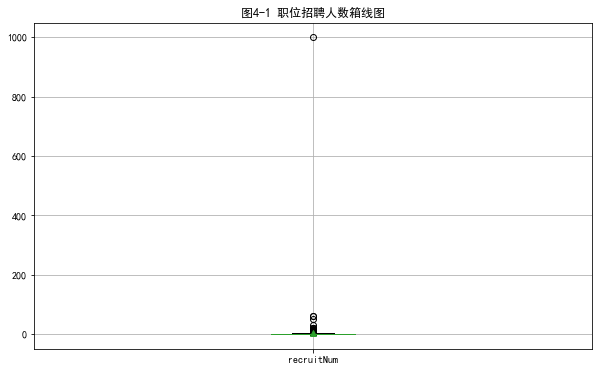

In [5]:
# 获取各变量的值信息

# 定性变量
# hangzhou_df['area'].value_counts()  # 公司所在县区（area）存在较多异常值
# hangzhou_df['quality'].value_counts()  # 公司性质（quality）存在异常值“不限”(6条)，需要把港澳台公式和学校\下级学院和事业单位归到其它
# hangzhou_df['size'].value_counts()     # 公司规模（size）存在异常值“不限”（10条）

# hangzhou_df['emplType'].value_counts()
# hangzhou_df['salary'].value_counts()  # 存在13条“薪资面议”

# hangzhou_df['eduLevel'].value_counts()
# hangzhou_df['workingExp'].value_counts()


# 定量变量
hangzhou_df[['recruitNum']].boxplot(sym='o',  # 异常点形状，参考marker
                                    vert=True,
                                    patch_artist=True,  # 上下四分卫框内是否填充，True为填充
                                    meanline=False, showmeans=True,  # 是否有均值线及其形状
                                    showbox=True,  # 是否显示箱线
                                    showcaps=True,  # 是否显示边缘线,
                                    showfliers=True,  # 是否显示异常值
                                    notch=False,  # 中间箱体是否缺口
                                    figsize=(10, 6),
                                    return_type='dict')
plt.title('图4-1 职位招聘人数箱线图')

**通过对各变量值的观察**：
1. quality 存在异常值“不限”（不存在公司性质为“不限”的类别）和部分数量较少的类别 -- 需要去除“不限”的公司性质，合并较少的类别到“其它”中）；
2. size 还存在异常值“不限”（不存在公司规模为“不限”的类别） -- 需要去除“不限”的公司类别；
3. recruitNum 存在异常值 -- 需要进行异常值处理   

**为了让数据适合分析，还需要**：
1. 将薪资水平 salary 拆分为 `“最低薪资”`和`“最高薪资”`，再由二者计算`“平均薪资水平”`；
2. 从职位详细描述 jobDetail 数据中提取出`“软件能力要求”`变量；
3. 将 jobDetail 数据中提取出所有内容写入txt文件中（生成词云图）
   
为了避免不必要的数据浪费，决定对数据集进行拆分，分为位置数据、文本数据、其他数据。由于要做的三个分析与数据一一对应，相互独立，所以分别对数据进行清洗。[最终预处理后的数据](#预处理后的数据说明)说明见下文。

### 数据清洗 Data Clean

**拆分数据**

In [6]:
# 位置数据
site_df = hangzhou_df.iloc[:, [0, 2]].dropna()  # 提取位置数据并清除缺失值
# 文本数据
txt_df = hangzhou_df[['jobDetail']]

# 其他数据
not_necessary_feature = ['city', 'area', 'welfare',
                         'businessArea', 'lon', 'lat', 'jobDetail', 'jobName']
data = hangzhou_df.drop(
    not_necessary_feature, axis=1)  # 去除不重要变量Z

**数据清洗**

In [7]:
# 公司性质 quality 数据清洗（不存在“不限”的公司性质；较少的类别合并到“其它”中）
data['quality'] = data['quality'].replace(
    {'不限': np.nan, '港澳台公司': '其它', '事业单位': '其它', '学校/下级学院': '其它'})  # 产生6缺失值

# 公司规模 size 数据清洗（不存在“不限”的公司规模）
data['size'] = data['size'].replace('不限', np.nan)  # 产生10缺失值

# 招聘人数 recruitNum 数据清洗（用箱线图判断异常值）
data['recruitNum'] = data['recruitNum'].replace(999, np.nan)  # 产生一条缺失值

# 去除所有含有缺失值的行
data = data.dropna()

print(data.shape)
data.head(3)

(1063, 8)


,company,size,quality,emplType,salary,recruitNum,eduLevel,workingExp
0,杭州微拍堂文化创意有限公司,100-499人,民营,实习,5K-8K,1.0,本科,不限
1,浙江华坤道威数据科技有限公司,100-499人,股份制企业,校园,4K-8K,1.0,硕士,无经验
2,印孚瑟斯技术（中国）有限公司杭州研发中心,1000-9999人,外商独资,全职,8K-10K,3.0,本科,3-5年


### 数据转换 Data Transform

**薪资水平（salary）数据预处理**

In [8]:
import re

data = data.drop(hangzhou_df[hangzhou_df['salary']
                             == '薪资面议'].index)    # 去除薪资水平中“薪资面议”数据

data['low_salary'] = data['salary'].apply(
    lambda x: int(re.search('(\d+)?K-', x).group(1)))    # 最低薪资
data['high_salary'] = data['salary'].apply(
    lambda x: int(re.search('K-(\d+)?', x).group(1)))    # 最高薪资
data['mean_salary'] = (data['low_salary'] + data['high_salary']
                       ) / 2                            # 平均薪资
data = data.drop('salary', axis=1)

**提取“软件能力要求”（software_ability）信息**  
软件能力要求（12个）：  
- 编程式数据分析工具：Python、R、MATLAB、Julia、SAS(5)
- 菜单式数据分析工具：Excel、SPSS、Eviews(3)
- 商业智能工具（可视化）BI：Tableau、Power BI (2) 
- 数据库工具：SQL（Oracle,MySQL，SQLServer）、MongoDB（2）


In [9]:
def del_english(st):
    '''
    删除全是英文与大量英文的字符串（因为存在全英文的JD,会干扰分析）
    '''
    all_pattern = re.compile(u'[\u4e00-\u9fa5]')
    p_pattern = re.compile('[a-zA-Z]')
    prop = (len(st) - len(re.findall(p_pattern, st))) / len(st)  # 非英文占总文本长度的比例
    if re.search(all_pattern, st) and (prop >= 0.8):
        return st
    else:
        return ''


def del_r(st):
    '''
    删除带有R的与R语言无关的内容
    '''
    st = st.replace('ERP', '').replace('VR', '').replace('ROI', '').replace(
        'EPR', '').replace('CRM', '').replace('HR', '').replace('CRF', '').replace('IAR', '')
    return st


def extract(st):
    '''
    在每条jd（type: str）中查找并提取要求的软件能力
    返回：列表
    '''
    software_ability = []  # 初始化“软件能力要求”变量
    # 编程式数据分析工具
    if ('python' in st) or ('Python' in st) or ('PYTHON' in st):
        software_ability.append('Python')
    if 'R' in st:
        software_ability.append('R')
    if ('matlab' in st) or ('MATLAB' in st) or ('Matlab' in st):
        software_ability.append('MATLAB')
    if ('julia' in st) or ('Julia' in st) or ('JULIA' in st):
        software_ability.append('Julia')
    if ('SAS' in st) or ('sas' in st):
        software_ability.append('SAS')
    # 菜单式数据分析工具
    if ('Excel' in st) or ('EXCEL' in st) or ('excel' in st):
        software_ability.append('Excel')
    if ('SPSS' in st) or ('spss' in st):
        software_ability.append('SPSS')
    if ('Eviews' in st) or ('eviews' in st) or ('EVIEWS' in st):
        software_ability.append('Eviews')
    # BI可视化工具
    if ('Tableau' in st) or ('tableau' in st):
        software_ability.append('Tableau')
    if ('Power BI' in st) or ('powerbi' in st) or ('power bi' in st) or ('PowerBI' in st):
        software_ability.append('Power BI')
    # 数据库工具
    sql_condition = ('SQL' in st) or ('sql' in st) or ('Orcale' in st) or ('orcale' in st) or ('ORACLE' in st) or ('MySQL' in st) or (
        'Mysql' in st) or ('mysql' in st) or ('SQLServer' in st) or ('SQL Server' in st) or ('sqlserver' in st) or ('sql server' in st)
    if sql_condition:
        software_ability.append('SQL')
    if ('mongodb' in st) or ('MongoDB' in st) or ('Mongodb' in st):
        software_ability.append('MongoDB')
    st = software_ability
    return st


# 删除文本数据 txt_df 中全是 英文 与 非英文占总长度比大于80%的内容（防止对变量提取产生干扰）
txt_df['jobDetail'] = txt_df['jobDetail'].apply(lambda x: del_english(x))
# 在其他数据中创建新变量软件能力要求 software
data['software_ability'] = txt_df['jobDetail'].apply(lambda x: del_r(x))

# 将JD里的英文数据全转为小写，方便查找. ×不可，因为R语言
# txt_df['software_ability'] = txt_df['software_ability'].apply(lambda x: x.lower())

# 提取软件能力要求信息
data['software_ability'] = data['software_ability'].apply(lambda x: extract(x))
data.head(3)

,company,size,quality,emplType,recruitNum,eduLevel,workingExp,low_salary,high_salary,mean_salary,software_ability
0,杭州微拍堂文化创意有限公司,100-499人,民营,实习,1.0,本科,不限,5,8,6.5,"[SAS, Excel, SPSS]"
1,浙江华坤道威数据科技有限公司,100-499人,股份制企业,校园,1.0,硕士,无经验,4,8,6.0,"[SAS, Excel, SPSS]"
2,印孚瑟斯技术（中国）有限公司杭州研发中心,1000-9999人,外商独资,全职,3.0,本科,3-5年,8,10,9.0,[]


In [10]:
# jobDetail信息写入txt文档
jobDetail = ''

for st in txt_df['jobDetail'].values:
    jobDetail += st

with open('Hangzhou_jd.txt', 'w', encoding='gb18030') as f:
    f.write(jobDetail)

print(len(jobDetail))

419978


### 预处理后的数据说明

位置数据  

|数据类别| 变量名	| 变量描述	|  
| -- | -- | -- | 
|公司基本信息|公司名称（company）|字符型变量。如：杭州扬冠网络科技有限公司|
|职位基本信息|所在县区（area）|定性变量。共11个水平：滨江区、江干区、余杭区、西湖区、拱墅区、萧山区、上城区、下城区、下沙、桐庐县、富阳区（存在大量缺失值）|



文本数据    

|数据类别| 变量名	| 变量描述	|  
|--| -- | -- |
|公司基本信息|公司名称（company）|字符型变量。如：杭州扬冠网络科技有限公司|
|职位基本信息|职位详细信息（jobDetail）|文本数据。包含岗位职责、工作内容、任职要求等信息| 


其他数据    

|数据类别| 变量名	| 变量描述	|  
| -- | -- | -- |
|公司基本信息|公司名称（company）|字符型变量。如：杭州扬冠网络科技有限公司|
||公司规模（size）|定性变量。共6个水平：20人以下、20-99人、100-499人、500-999人、1000-9999、10000人以上| 
||公司性质(quality)|定性变量。共7个水平：民营、股份制企业、上市公司、合资、外商独资、国企、其他| 
|职位基本信息|雇佣类型（emplType）|定性变量。共4个水平：全职、实习、校园、兼职/临时| 
||招聘人数（recruitNum）|数值型变量。取值范围:0-60| 
||最低薪资（low_salary）|数值型变量。取值范围：1-50千元/月| 
||最高薪资（high_salary）|数值型变量。取值范围：2-70千元/月| 
||平均薪资（mean_salary）|数值型变量(（low_salary+high_salary）/2)。取值范围：1.5-60千元/月|
|职位要求信息|学历要求（eduLevel）|定性变量。共6个水平:硕士、本科、大专、中专、中技、不限|
||工作经验要求（workingExp）|定性变量。共7个水平：不限、无经验、1年以下、1-3年、3-5年、5-10年、10年以上| 
||软件能力要求（software_ability）|定性变量，设定12个水平，实际8个水平|

__________________________________________

## 数据分析

### 招聘详细描述信息分析

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\mizhu\AppData\Local\Temp\jieba.cache
Loading model cost 1.263 seconds.
Prefix dict has been built succesfully.


(-0.5, 799.5, 599.5, -0.5)

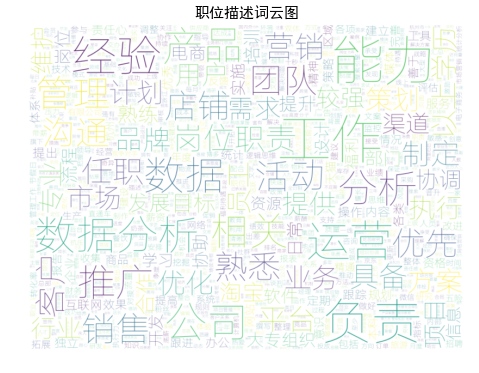

In [10]:
# 词云可视化
import jieba
from collections import Counter
from wordcloud import WordCloud

# 招聘详细信息分词

# 清理数据，替换不需要的字符串（只保留汉字）


def clean_str(line):
    line.strip('\n')
    line = re.sub(r"[^\u4e00-\u9fff]", "", line)
    line = re.sub(
        "[0-9a-zA-Z\-\s+\.\!\/_,$%^*\(\)\+(+\"\')]+|[+——！，。？、~@#￥%……&*（）<>\[\]:：★◆【】《》;；=?？]+", "", line)
    return line.strip()

# 加载停用词


def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        stopwords = [line.strip('\n') for line in f.readlines()]
    return stopwords


stopwords = load_stopwords('stopwords.txt')


def split_words(file_path):
    '''
    - file_path: 文本文件路径
    - return: words, 处理、分词之后的有效词语
    '''
    words = []
    with open(file_path, 'rb') as f:
        for line in f.readlines():
            line = line.strip().decode("utf-8", 'ignore')
            line = clean_str(line)
            if len(line) == 0:
                continue
            seg_list = list(jieba.cut(line, cut_all=False))   # 精确模式
            for x in seg_list:
                if len(x) <= 1:
                    continue
                if x in stopwords:
                    continue
                words.append(x)
    return words


# 得到字典形式的词频数据
words = split_words('Hangzhou_jd.txt')
words = dict(Counter(words))


# 为了显示中文，加载字体汉庭仪旗黑
font_path = 'HYQiHei-25JF.otf'
wc = WordCloud(font_path=font_path, background_color="white", max_words=1000,
               max_font_size=100, random_state=42, width=800, height=600, margin=2)

wc.generate_from_frequencies(words)

plt.figure(figsize=(8, 6))
plt.imshow(wc, interpolation="bilinear")  # 绘制并平滑显示
plt.title('职位描述词云图', fontsize=15)
plt.axis('off')  # 不显示坐标

可以直观的看到，在数据分析岗的职位详细描述信息中，“经验”、“能力”、“负责”等词被提到较多，这符合现实认知，说明企业对于应聘者首先考察的是其“经验”如何、“能力”高低、“负责”与否。另外，数据分析岗最基础的就是“数据”和“分析”，在词云图中也很好的得到了展现。此外，还有“运营”、“销售”等词词频也较高，而这些正是数据分析的一些发展方向。

### 基本信息描述性分析

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

#### 公司基本信息分析

Text(0.5,1,'图5-2 公司性质柱状图')

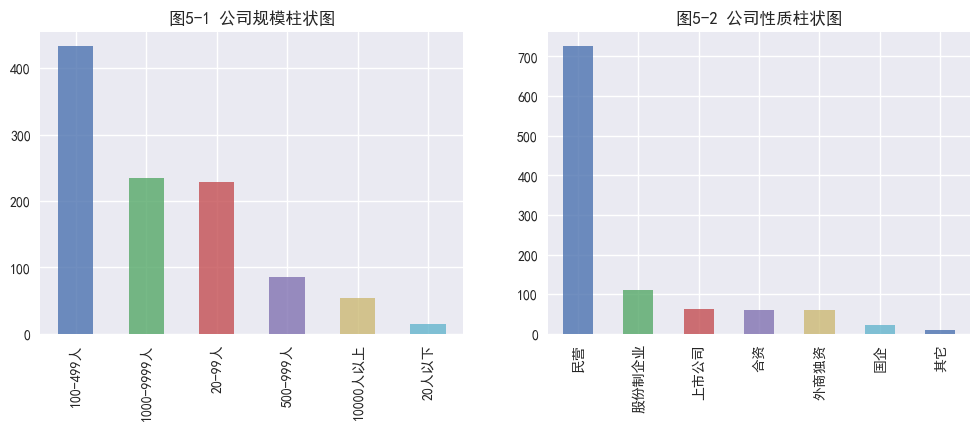

In [12]:
# 公司基本信息包括 公司规模 size、公司性质 quality
size = data['size'].value_counts()
quality = data['quality'].value_counts()


fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=100)

size.plot.bar(alpha=0.8, ax=axes[0])
axes[0].set_title('图5-1 公司规模柱状图')
quality.plot.bar(alpha=0.8, ax=axes[1])
axes[1].set_title('图5-2 公司性质柱状图')

由图5-1 可知：
- 公司规模为100-499人的中小型企业对于数据分析人才的需求量最大，且遥遥领先，说明一般中小型企业已经有了一定造血能力，也能产生充足的数据以供分析；
- 1000-9999人的大型企业与20-99人的小型企业的需求也不小，一般来说大型企业因为自身的数据量非常庞大，对于数据足够重视，所以对数据分析师也会有较大需求，而小型企业亟需提高业绩，也会产生一定的需求；
- 而500-999人的中大型企业、10000人以上的超大型企业对数据分析师的需求较为一般，一者这类公司本身就会非常多的数据分析人才，二者这类规模庞大的公司本身的数量就是有限的；
- 20人以下的超小型企业对数据分析师的需求较小，可以理解为这类公司本身缺乏有价值的数据，部门设立是不完善的。   

由图5-2 可知：
- 民营企业对于数据分析人才的需求占据绝大部分

#### 职位基本信息分析

**职位位置分布（热力图）**

In [13]:
# 杭州发布招聘数在各县区的分布
# 需要事先安装中国城市地图包

from pyecharts import Map

site = site_df.groupby('area').count().reset_index().rename(
    columns={'company': 'count'})   # 各地区的计数数据

map = Map("图5-1 杭州市各地区数据分析岗招聘数热力图", title_color="#fff", title_pos="center",
          width=1200,  height=600, background_color='#404a59')
attr = site['area']
value = site['count']
map.add("", attr, value, maptype='杭州', visual_range=[0, site.max(
).values[1]+1], visual_text_color="#fff",   symbol_size=15, is_visualmap=True, is_label_show=True)
map.render()

ERROR:lml.utils:failed to import pyecharts_snapshot
Traceback (most recent call last):
  File "D:\Anaconda\lib\site-packages\lml\utils.py", line 43, in do_import
    plugin_module = __import__(plugin_module_name)
ModuleNotFoundError: No module named 'pyecharts_snapshot'


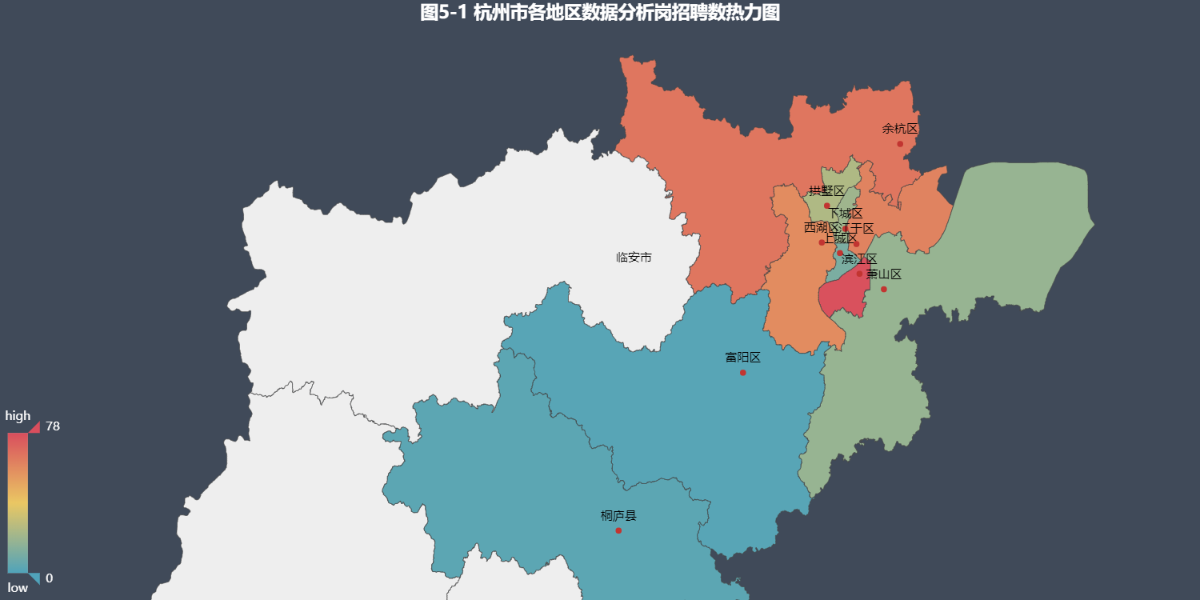

由图5-1 着色部分可知，相对于其他县区，杭州市的滨江区对于数据分析人才的需求最大，余杭区占其次，再者是西湖区与江干区。而富阳区以及桐庐县的岗位需求相对较低。一定程度上，地区对数据分析人才的需求大小也对应了其经济发展的程度的高低。若期望未来职位能有好的发展，择选滨江、余杭等地区就业会是不错的选择。

**职位类型、招聘人数、平均薪资水平**

Text(0.5,1,'图5-5 平均薪水直方图')

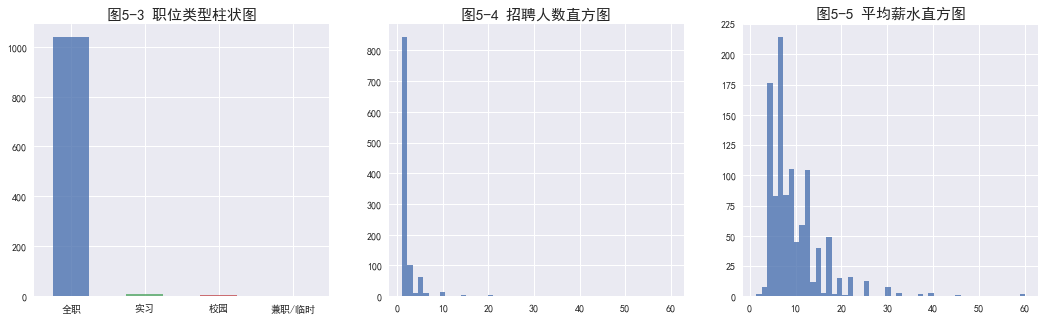

In [14]:
emplType = data['emplType'].value_counts()
recruitNum = data['recruitNum']
salary = data['mean_salary']

# 创建 1 * 3 子图
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

emplType.plot.bar(alpha=0.8, ax=axes[0], rot=0)
axes[0].set_title('图5-3 职位类型柱状图', fontsize=15)

recruitNum.hist(bins=50, histtype='bar', align='mid', alpha=0.8, ax=axes[1])
axes[1].set_title('图5-4 招聘人数直方图', fontsize=15)

salary.hist(bins=50, histtype='bar', align='mid', alpha=0.8, ax=axes[2])
axes[2].set_title('图5-5 平均薪水直方图', fontsize=15)

# data['mean_salary].describe()
# hangzhou_df.iloc[data[data['mean_salary'] == 1.500000].index]
# hangzhou_df.iloc[data[data['mean_salary'] == 60.000000].index]

由图5-3 可知，公司总是更偏爱于招聘全职的数据分析师，雇佣类型实习和校园相似，需求量极小，兼职\临时可能是公司需要数据分析师来解决一个临时的难题；  

由图5-4 可以看到，这个图非常丑陋。从图中看数据呈现严重的右偏分布，且存在不少极端值，那这些极端值究竟是否是异常值呢，说不好。因本人对于公司一般招聘的人数需求不了解，但这类社会经济问题，通常是会存在不少极端值的（比如大公司数据部门需要彻底换血等等）。唯一可以确切的说的是，公司招聘数据分析师的人数一般会控制在1-10人；   

由图5-5 可知，职位平均薪水是呈现右偏分布的。具体来说，数据分析岗的平均薪水的均值为 9.82千元/月，中位数为 8.00千元/月，这以现象大致符合认知，即存在少数的高薪精英人才拉高了平均值。在本数据中，平均薪资最小值为 1.50千元/月，所对应的招聘职位是国企的“实习研究员”，一般国企给实习生开的工资是很寒酸的。

#### 岗位要求信息分析

**学历要求、工作经验要求**

Text(0.5,1,'图5-7 工作经验要求饼图')

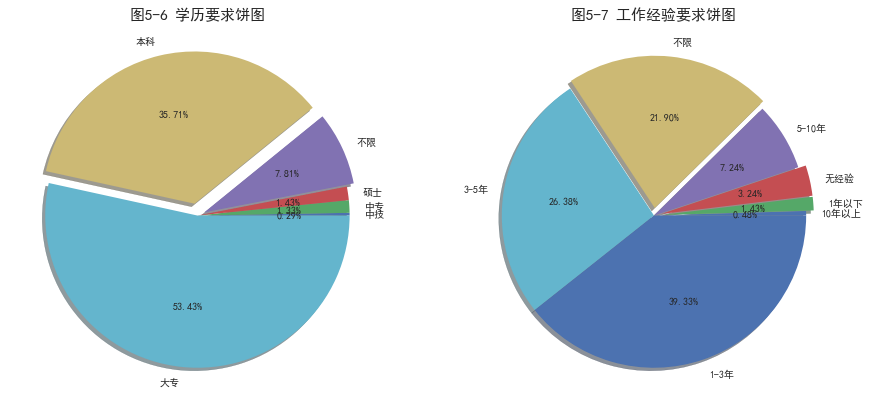

In [15]:
eduLevel = data['eduLevel'].value_counts().sort_values(ascending=True)
workingExp = data['workingExp'].value_counts().sort_values(ascending=True)


fig, axes = plt.subplots(1, 2, figsize=(15, 7))
axes[0].axis('equal')  # 保证长宽相等
axes[0].pie(eduLevel, labels=eduLevel.index, explode=[0, 0, 0, 0.05,
                                                      0.08, 0], autopct='%.2f%%', pctdistance=0.6, shadow=True)
axes[0].set_title('图5-6 学历要求饼图', fontsize=15)

axes[1].axis('equal')
axes[1].pie(workingExp, labels=workingExp.index, explode=[
            0, 0.05, 0.05, 0, 0.05, 0, 0], autopct='%.2f%%', pctdistance=0.6, shadow=True)
axes[1].set_title('图5-7 工作经验要求饼图', fontsize=15)

由上图5-6 可以看到，公司对求职者的学历要求更多的是大专，占比 53.43%，本科学历占其次，占比35.71%，而更低水平的中专、中技学历的求职者很难找到心仪的数据分析工作；  
由图5-7 可以看到，公司对求职者的工作经验一般都会要求 1-3年，占比 39.33%，因为公司培养没有实践经验的求职者是需要花费一定的时间与精力的（培养后的求职者可能还会跳槽……），出于这类求职者已经有了一定的工作经验，自然也就更受公司青睐。工作经验在 3-5年的数据分析师往往已经是行业老手也是比较抢手的，占比 26.38%。而在数据分析岗浸淫了10年以上的求职者本身就是凤毛麟角，故相对而言公司对这类求职者的需求也是最低的。

**薪水与要求之间的关系**

(0, 45)

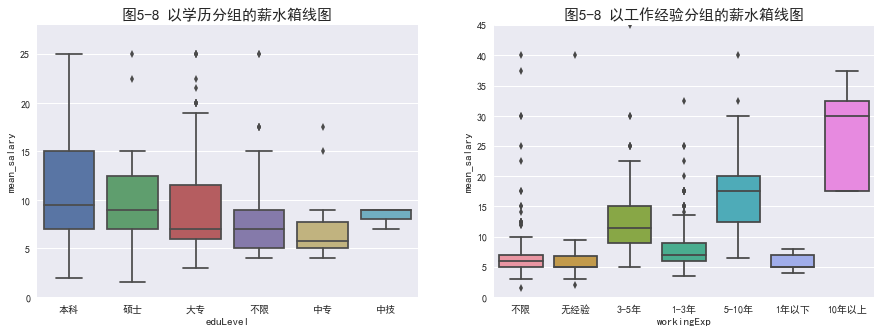

In [16]:
# 薪水的分组箱线图

# plt.figure(figsize=(20, 10))
# sns.boxplot(x='eduLevel', y='mean_salary', data=data, hue='workingExp')

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(x='eduLevel', y='mean_salary', data=data, ax=axes[0], )
axes[0].set_title('图5-8 以学历分组的薪水箱线图', fontsize=15)
axes[0].set_ylim([0, 28])    # 为了更直观，忽视异常值

sns.boxplot(x='workingExp', y='mean_salary', data=data, ax=axes[1])
axes[1].set_title('图5-8 以工作经验分组的薪水箱线图', fontsize=15)
axes[1].set_ylim([0, 45])

# ！！如果对变量设置category类型或排一下序会更直观

由上图5-8 可见，箱子的长度表示数据的离散程度，本科学历在薪资水平的离散程度最大，分布最广，一方面是因为本科对应的数据多，另一方面也说明了本科生的两极分化更严重，可以很优秀，也可以很差劲；
由图5-9 可见，工作经验越丰富，薪资水平的中位数也就相对越大，工作经验与薪资水平之间存在着正相关。   
综上，想提高薪水，学历越高越有优势，本科生不可好乐有荒，也要注重自身多维度能力的培养，要多实习，丰富自己的工作经验也是很好很好的。

**软件能力要求**

Text(0.5,1,'图5-9 杭州市数据分析岗招聘软件能力要求条形图')

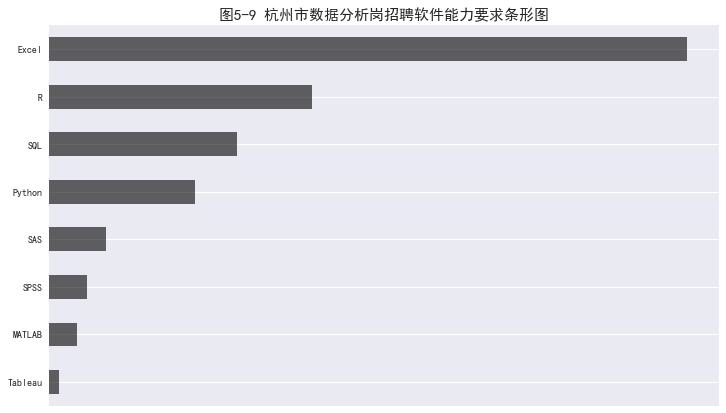

In [17]:
# 软件能力要求（12个）：
# - 编程式数据分析工具：Python、R、MATLAB、Julia、SAS(5)
# - 菜单式数据分析工具：Excel、SPSS、Eviews(3)
# - 商业智能工具（可视化）BI：Tableau、Power BI (2)
# - 数据库工具：SQL（Oracle,MySQL，SQLServer）、MongoDB（2）

software = []  # 初始化一个列表
soft_df = data['software_ability'].apply(pd.Series).dropna(how='all')
for a in soft_df.values:
    for b in a:
        if b is not np.nan:
            software.append(b)

soft_count = pd.DataFrame(
    pd.Series(software).value_counts().sort_values(), columns=['count'])

# 绘制条形图
soft_count.plot.barh(alpha=0.6, color='k', rot=0,
                     legend=False, figsize=(12, 7))
plt.xticks([])
plt.title('图5-9 杭州市数据分析岗招聘软件能力要求条形图', fontsize=15)

从上图5-9 可以看到：  
- 目前杭州市数据分析岗对于Excel的要求仍然是最普遍的，因为Excel方便快捷，能满足工作中绝大部分的分析工作；
- R语言占其次（有可能文本中R语言的干扰信息清洗的不够彻底，导致R语言的频数虚高，当然不可否认的是 R语言在数据科学领域是非常强大的），出于其强大完整的数据分析功能，由统计学家制作的R语言更受统计学专业背景的人群的青睐；
- SQL作为数据库语言中受众最广的语言也是众多企业对数据分析求职者的基本标准之一；
- 企业也会要求求职者掌握Python。在数据分析领域Python与R语言的特性相近，功能相近，在数据科学领域Python会更胜一筹，而且Python更符合潮流。与R语言类似，在数据分析岗，对于Python，更多的是一个加分项；
- SAS企业用到的不多，因为是非开源软件，费用昂贵，求职者也很少有接触到SAS学习的机会；
- SPSS专注于统计调查，简单且性能强大，但是也不是免费的；
- MATLAB同理；
- 至于Tableau等商业智能软件，企业对求职者一般很少做要求，因为商业智能在一定程度上脱离了数据分析的范畴了，可以作为加分项；
- 其余列出的数据分析相关软件没有出现在条形图中，说明在数据分析领域，这些软件还不是或者说还没有成为主流。

### 软件能力要求分析

In [18]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# 数据准备
dataset = data['software_ability'].apply(
    pd.Series).dropna(how='all').values.tolist()

for i in dataset:
    while np.nan in i:
        i.remove(np.nan)

# 建立模型
te = TransactionEncoder()
# 转换数据集
te_ary = te.fit_transform(dataset)
# 转换为DataFrame
df = pd.DataFrame(te_ary, columns=te.columns_)

# 通过 Apriori 算法生成频繁项集
frequent_itemsets = apriori(
    df, min_support=0.1, use_colnames=True)  # 频繁项集最小支持度为0.1
frequent_itemsets[frequent_itemsets.itemsets.apply(
    lambda x: len(x)) >= 2]  # 只选择长度大于等于2的频繁项集

# 执行关联规则
association_rules(frequent_itemsets, metric="confidence",
                  min_threshold=0.6)  # 置信度阈值为 0.6

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Python),(SQL),0.149038,0.192308,0.100962,0.677419,3.522581,0.0723,2.503846


结果显示："Python$→$SQL; support=0.1, confidence=0.6, lift=3.5".   
杭州有67.74%的企业在要求求职者能掌握 Python 时，同时掌握SQL。  
所以发展火爆，势头未减的Python要好好学，SQL也要会啊，最起码得保证基本的增删查改吧！这样才能提升自己的求职竞争力！

## 总结

通过对智联招聘杭州站的数据分析岗的数据进行分析，根据结果得到了以下结论：
1. 公司的基本信息：
- 公司规模为100-499人的中小型企业对于数据分析人才的需求量最大；
- 民营企业提供较多的数据分析岗；
2. 职位的基本信息：
- 相对而言，择选滨江区、余杭区进行就业，对于数据分析师发展会有更好的发展；
- 数据分析岗几乎都是全职的，其薪资仍比较可观；
3. 岗位要求信息分析
- 学历要求最多的是中等学历的大专，工作经验要求最多的是1-3年；
- 学历一般与薪资水平正相关，工作经验也是；
- 本科生薪水的离散程度最大；
- Excel是公司对数据分析求职者最普遍最基本的要求，公司也很看重SQL，Python\R作为加分项；
- 要求求职者会Python的公司一般也倾向于要求求职者会SQL。  

根据结论，我认为作为数据分析岗的求职者，可以择选滨江区、余杭区中的中型或中小型企业作为理想的归宿。如果可以，尽量提升自己的学历（而且这个时代本科生都满地走了），并且寻找机会增加自己的实践经验（一定程度上比学历更重要），可以好乐，但是要无荒，需要努力提升自己的专业水平与业务理解。至于软件，Excel和SQL是必须的，Python、R择其一，要达到掌握及以上的程度。  
都说互联网寒冬，谈及色变，但换个角度想想，又何尝不是机遇呢？最重要的还是丰富自己的经验，修炼自己的能力，端正自己的态度啊。  
引用雪莱的一句话：“If winter comes,can spring be far behind?”（冬天来了，春天还会远吗）